# Cooling Loops in a Stellar Corona

In [49]:
#import pdb
import datetime
import os
import subprocess
import multiprocessing

import dask.distributed
from scipy.io import readsav
from scipy.interpolate import splev
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import sunpy.sun.constants
from sunpy.map import Map,GenericMap
import astropy.units as u
import yt
import h5py
from astropy.coordinates import SkyCoord
import sunpy.cm

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,UniformHeating
from synthesizAR.instruments import InstrumentHinodeXRT

from sav_converter import sav_to_hpc_map

%matplotlib inline

In [2]:
client = dask.distributed.Client()
client

Client Scheduler: tcp://127.0.0.1:44451 Dashboard: http://127.0.0.1:8787,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


## Construct SunPy Map from IDL Data

In [3]:
hemispheremap0 = sav_to_hpc_map('0long166800.sav',pad=10)
hemispheremap180 = sav_to_hpc_map('180long166800.sav',pad=10)

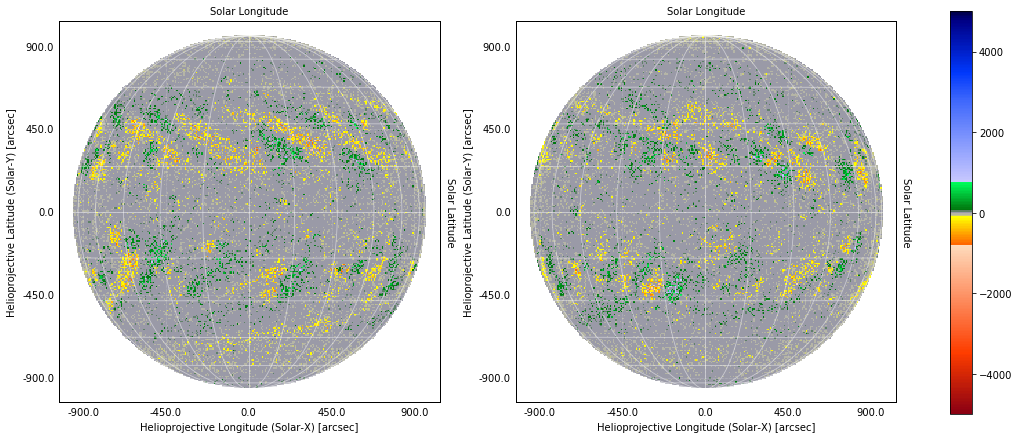

In [4]:
fig = plt.figure(figsize=(15,7))
cax = fig.add_axes((0.95,0.1,0.02,0.8))
ax = fig.add_subplot(121,projection=hemispheremap0)
hemispheremap0.plot(axes=ax,title=False)
hemispheremap0.draw_grid(axes=ax)
ax = fig.add_subplot(122,projection=hemispheremap180)
im = hemispheremap180.plot(axes=ax,title=False)
hemispheremap180.draw_grid(axes=ax)
fig.colorbar(im,cax=cax)

## Create SynthesizAR Field Object

Now that we have our data in terms of SunPy maps, we are ready to pass it to synthesizAR. For the sake of simplicity, we'll only choose the 0-longitude-centered map (on the left above).

In [5]:
field = synthesizAR.Skeleton(hmi_fits_file=hemispheremap0,
                             resample=u.Quantity([125,125],u.pixel)
                            )

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [6]:
field.extrapolate_field(zshape=100, zrange=u.Quantity([0,2000],u.arcsec))

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:81: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only 

True


/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/storage-home/w/wtb2/anaconda3/envs/s

In [7]:
field.extract_streamlines(10000,mask_threshold=0.01,safety=5,loop_length_range=[5e9,1e11]*u.cm,close_threshold=0.025)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:64: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/util/util.py:65: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2018-01-10 18:30:23,019 AMRKDTree rebuilt, Final Volume: 2.941929e+33
Streamlining: 100%|██████████| 10000/10000 [00:09<00:00, 1006.46it/s]
yt : [INFO     ] 2018-01-10 18:30:45,459 AMRKDTree rebuilt, Final Volume: 2.941929e+33
Streamlining: 100%|██████████| 4527/4527 [00:04<00:00, 960.80it/s] 
yt : [INFO     ] 2018-01-10 18:30:55,439 AMRKDTree rebuilt, Final Volume: 2.941929

tornado.application - ERROR - Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7f5509286a60>, <tornado.concurrent.Future object at 0x7f550932a0f0>)
Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/comm/core.py", line 185, in connect
    quiet_exceptions=EnvironmentError)
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/gen.py", line 1055, in run
    value = future.result()
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/concurrent.py", line 238, in result
    raise_exc_info(self._exc_info)
  File "<string>", line 4, in raise_exc_info
tornado.gen.TimeoutError: Timeout

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/tornado/ioloop.py", line 605, in _r

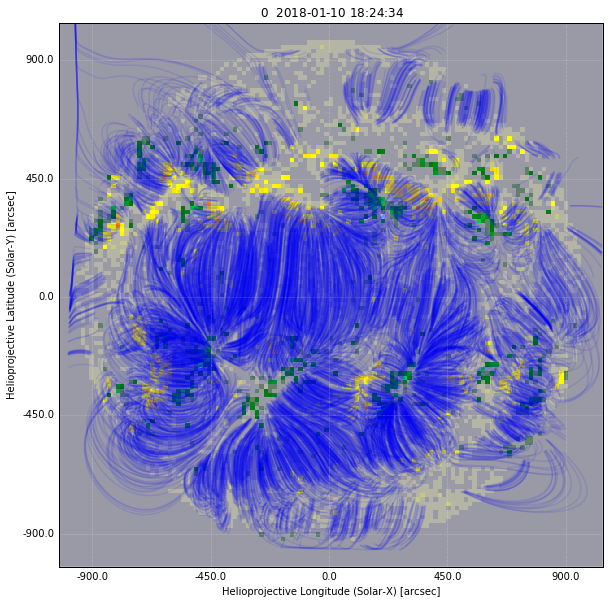

In [8]:
field.peek(alpha=0.1)

In [9]:
field.make_loops()

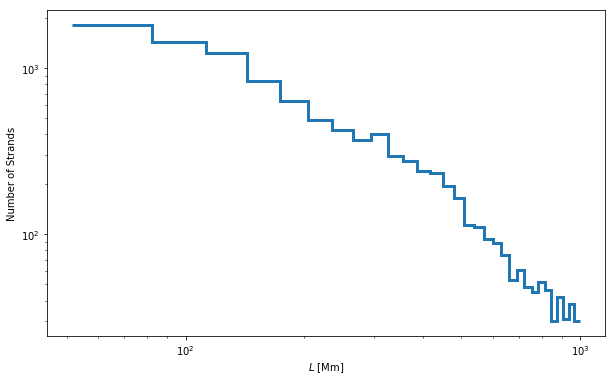

In [10]:
plt.figure(figsize=(10,6))
plt.hist([loop.full_length.to(u.Mm).value for loop in field.loops],histtype='step',lw=3,bins='scott');
plt.xlabel(r'$L$ [Mm]')
plt.ylabel(r'Number of Strands')
plt.xscale('log')
plt.yscale('log')

yt : [INFO     ] 2018-01-10 18:32:48,234 Projection completed
yt : [INFO     ] 2018-01-10 18:32:48,236 xlim = -71109566720.267517 74579592431.196075
yt : [INFO     ] 2018-01-10 18:32:48,237 ylim = -71109566730.467682 74579592420.995911
yt : [INFO     ] 2018-01-10 18:32:48,238 xlim = -71109566720.267517 74579592431.196075
yt : [INFO     ] 2018-01-10 18:32:48,239 ylim = -71109566730.467682 74579592420.995911
yt : [INFO     ] 2018-01-10 18:32:48,241 Making a fixed resolution buffer of (('stream', 'Bz')) 800 by 800
yt : [WARNING  ] 2018-01-10 18:32:48,266 Plot image for field ('stream', 'Bz') has both positive and negative values. Min = -1070339223.436661, Max = 1105819663.658072.
yt : [WARNING  ] 2018-01-10 18:32:48,267 Switching to symlog colorbar scaling unless linear scaling is specified later
yt : [INFO     ] 2018-01-10 18:32:48,641 Projection completed
yt : [INFO     ] 2018-01-10 18:32:48,742 Projection completed



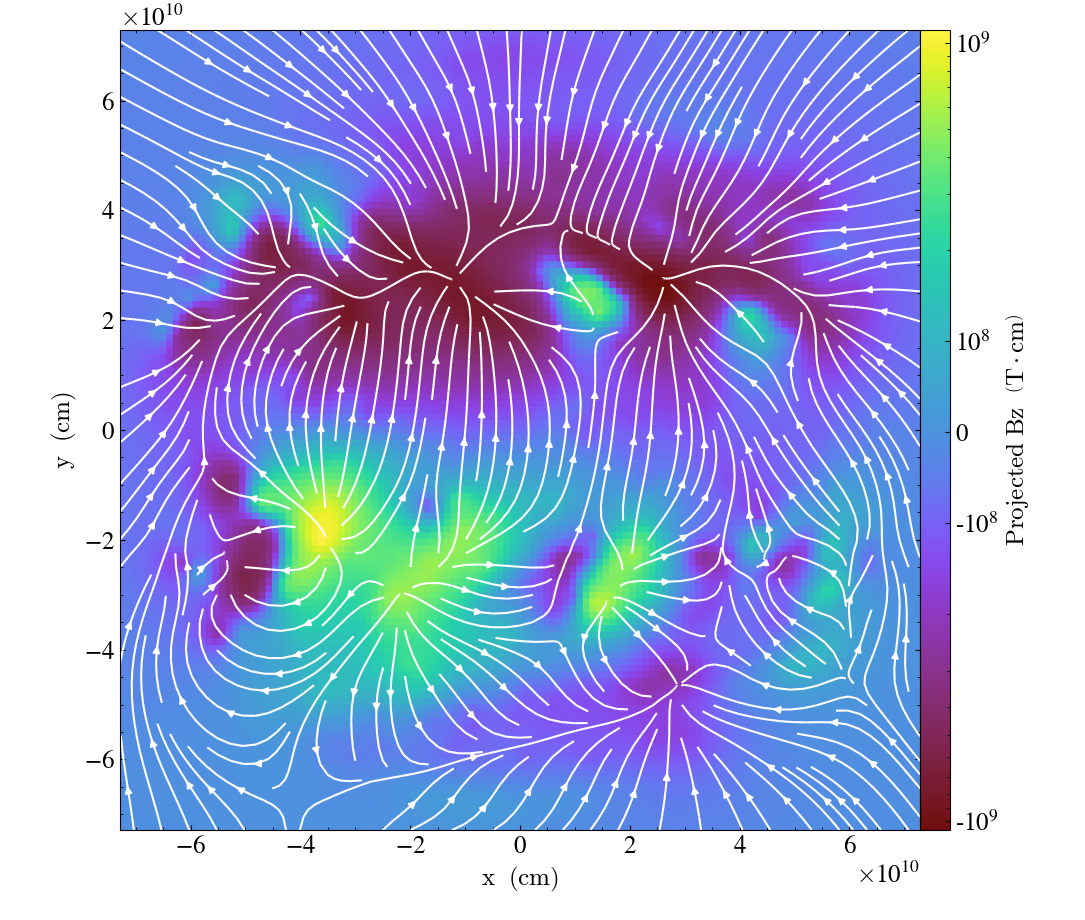

In [11]:
center=(field.extrapolated_3d_field.domain_center
        +np.array([0,0,-0.4])*field.extrapolated_3d_field.domain_width)
p = yt.ProjectionPlot(field.extrapolated_3d_field,'z','Bz',
                 #origin='lower-right-domain',
                 axes_unit='cm',
                 #center=center,
                 #width=((1*extrap_field.domain_width.value[1],'cm'),
                 #       (1*extrap_field.domain_width.value[2],'cm'))
                )
p.annotate_streamlines('Bx','By',density=2,plot_args={'color':'w'})
#p.set_zlim('Bz',-1e3,1e3)
#p.set_log('Bz',True,linthresh=5e-2)
p.show()

## Heating Model
To start off with, we'll just use a simple cooling model that will last around 5000 s

In [12]:
heating_options = {
    'duration':200,
    'average_waiting_time':4800,
    'duration_rise':100,
    'duration_decay':100,
    'stress_level':0.3
}
heating_model = UniformHeating(heating_options)

In [13]:
ih = synthesizAR.util.InputHandler('/storage-home/w/wtb2/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['total_time'] = 5e3
base_config['use_adaptive_solver'] = True
base_config['use_flux_limiting'] = True
base_config['calculate_dem'] = False
base_config['heating']['partition'] = 1.0
base_config['heating']['background'] = 1e-6
base_config['force_single_fluid'] = False
base_config['tau_max'] = 200.0

In [14]:
ebtel_interface = EbtelInterface(base_config, heating_model,
                                 '/storage-home/w/wtb2/data/stellar_coronae/test_0longitude_cooling/hydro_config/',
                                 '/storage-home/w/wtb2/data/stellar_coronae/test_0longitude_cooling/hydro_results/')

In [15]:
field.configure_loop_simulations(ebtel_interface)

FloatProgress(value=0.0)

In [16]:
def ebtel_runner(loop):
    subprocess.call([os.path.join('/storage-home/w/wtb2/codes/','ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [17]:
pool = multiprocessing.Pool()

In [18]:
runs = pool.map_async(ebtel_runner,field.loops)
runs.wait()

In [19]:
field.load_loop_simulations(ebtel_interface,
                            savefile='/storage-home/w/wtb2/data/stellar_coronae/test_0longitude_cooling/loop_parameters.h5'
                           )

FloatProgress(value=0.0)

Text(0.5,0,'$t$ [s]')

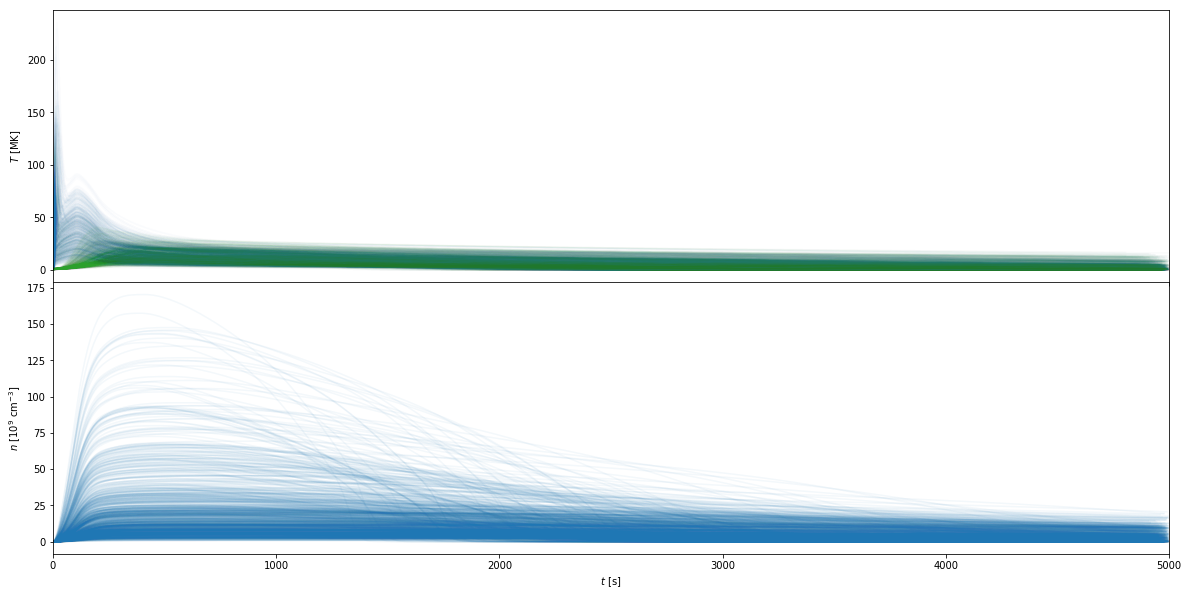

In [20]:
fig,axes = plt.subplots(2,1,figsize=(20,10),sharex=True)
plt.subplots_adjust(hspace=0.)
for loop in field.loops[::10]:
    axes[0].plot(loop.time,loop.electron_temperature[:,0].to(u.MK),color='C0',alpha=0.01)
    axes[0].plot(loop.time,loop.ion_temperature[:,0].to(u.MK),color='C2',alpha=0.01)
    axes[1].plot(loop.time,loop.density[:,0]/1e9,color='C0',alpha=0.05)
axes[0].set_xlim([0,base_config['total_time']])
axes[0].set_ylabel(r'$T$ [MK]')
axes[1].set_ylabel(r'$n$ [10$^9$ cm$^{-3}$]')
axes[1].set_xlabel(r'$t$ [s]')

In [21]:
field.save('/storage-home/w/wtb2/data/stellar_coronae/test_0longitude_cooling/field_checkpoint')

In [ ]:
field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/stellar_coronae/test_0longitude_cooling/field_checkpoint/')

## Synthetic Observations

In [31]:
xrt = InstrumentHinodeXRT([0, 5000]*u.s)

In [32]:
observer = synthesizAR.Observer(field,[xrt],parallel=True)

In [33]:
observer.build_detector_files('/storage-home/w/wtb2/data/stellar_coronae/test_0longitude_cooling/',
                              ds=field._convert_angle_to_length(2*u.arcsec))

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev547-py3.6.egg/synthesizAR/instruments/base.py:117: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  delta_x = np.fabs(field.clipped_hmi_map.xrange[1] - field.clipped_hmi_map.xrange[0])
/storage-home/w/wtb2/anaconda3/envs/synthesizar/li

In [34]:
xrt.total_coordinates.shape

(1627463, 3)

In [35]:
tasks = observer.flatten_detector_counts()

In [36]:
tasks['Hinode_XRT_parameters'].compute()

In [37]:
tasks['Hinode_XRT_counts'].compute()

In [ ]:
tasks = observer.bin_detector_counts('/storage-home/w/wtb2/data/stellar_coronae/test_0longitude_cooling')

In [ ]:
jobs = client.compute(tasks['Hinode_XRT'])

In [ ]:
jobs[0].result()

In [ ]:
xrt.bins.z

In [ ]:
jobs=None

In [ ]:
client.restart()

## Sandbox

In [63]:
channel = xrt.channels[1]
channel['name']

'open-Al_mesh'

In [64]:
with h5py.File(xrt.counts_file, 'r') as hf:
    weights = np.array(hf[channel['name']][100, :])
    units = u.Unit(hf[channel['name']].attrs['units'])
    coordinates = u.Quantity(hf['coordinates'], hf['coordinates'].attrs['units'])

In [65]:
hist, edges = np.histogramdd(coordinates.value, bins=xrt.bins, range=xrt.bin_range, weights=weights)

In [66]:
counts = np.dot(hist, np.diff(edges[2])).T

In [67]:
header = xrt.make_fits_header(field,channel)

In [68]:
counts_b = gaussian_filter(counts,(5,5))#xrt.psf_smooth(counts,header)

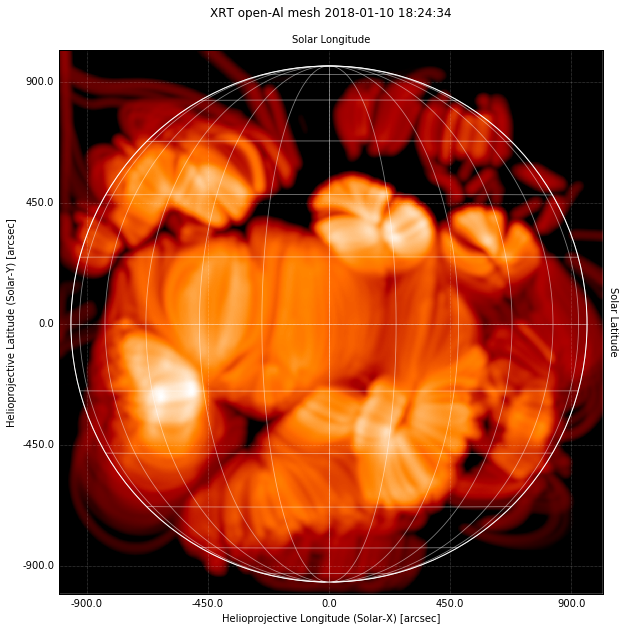

In [69]:
plt.figure(figsize=(10,10))
m = Map(counts_b,header)
m.plot(norm=matplotlib.colors.SymLogNorm(1e-6,vmin=1,vmax=5e5))
m.draw_limb()
m.draw_grid()

In [46]:
temperature = np.logspace(5,8,200)

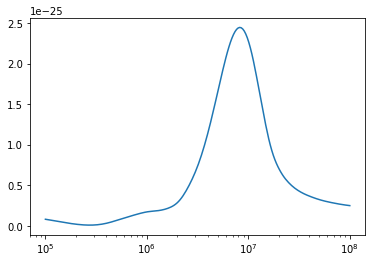

In [48]:
plt.plot(temperature,splev(temperature,xrt.channels[1]['temperature_response_spline']))
plt.xscale('log')